<a href="https://colab.research.google.com/github/hoangdh1/TrafficSignClassification/blob/main/TrafficSignClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing data

In [1]:
import tensorflow as tf
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>

Mount Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
pwd

'/content'

## Import các thư viện

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import joblib

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Load data

In [5]:
cd /content/gdrive/MyDrive/BTL_ML/data


/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/data


In [6]:
with open("/content/gdrive/MyDrive/BTL_ML/data/german-traffic-signs/test.p", mode="rb") as f:
  test = pickle.load(f)
with open("/content/gdrive/MyDrive/BTL_ML/data/german-traffic-signs/train.p", mode="rb") as f:
  train = pickle.load(f)
with open("/content/gdrive/MyDrive/BTL_ML/data/german-traffic-signs/valid.p", mode="rb") as f:
  valid = pickle.load(f)

## Check dataset

In [7]:
train

{'coords': array([[  6,   5,  21,  20],
        [  6,   6,  22,  22],
        [  5,   6,  22,  23],
        ...,
        [ 17,  15, 178, 155],
        [ 17,  15, 183, 160],
        [ 20,  18, 211, 184]], dtype=uint8),
 'features': array([[[[ 28,  25,  24],
          [ 27,  24,  23],
          [ 27,  24,  22],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  25],
          [ 31,  27,  26]],
 
         [[ 29,  26,  25],
          [ 27,  25,  23],
          [ 27,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         [[ 28,  26,  26],
          [ 27,  25,  23],
          [ 26,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         ...,
 
         [[ 27,  24,  23],
          [ 28,  25,  24],
          [ 30,  25,  24],
          ...,
          [ 27,  24,  23],
          [ 28,  24,  22],
          [ 29,  25,  22]],
 
         [[ 28,  23,  23],
       

Mỗi tập là một dictionary với 4 cặp key/value:

'features' là một mảng 4D chứa dữ liệu raw pixel của hình ảnh biển báo giao thông (số lượng, chiều rộng, chiều cao, chanels)

'label' là một mảng 1D chứa id nhãn / lớp của biển báo giao thông. Tệp signnames.csv chứa id -> ánh xạ tên cho mỗi id.

'sizes' là danh sách chứa các tuples, (chiều rộng, chiều cao) đại diện cho chiều rộng và chiều cao ban đầu của hình ảnh.

'coords' là một danh sách chứa các tuples, (x1, y1, x2, y2) đại diện cho tọa độ của một bounding box xung quanh sign trong ảnh.

In [8]:
trainX = train["features"]
trainY = train["labels"]

validX = valid["features"]
validY = valid["labels"]

testX = test["features"]
testY = test["labels"]

In [9]:
trainX.shape

(34799, 32, 32, 3)

In [10]:
validX.shape

(4410, 32, 32, 3)

In [11]:
testX.shape

(12630, 32, 32, 3)

In [12]:
dataX = np.concatenate((trainX, validX, testX),axis=0)
dataY = np.concatenate((trainY, validY, testY),axis=0)

In [13]:
dataX.shape

(51839, 32, 32, 3)

## Visualize data distribution

In [14]:
#Số nhãn
n_classes = len(set(trainY))
n_classes

43

In [15]:
cd /content/gdrive/MyDrive/BTL_ML/data

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/data


In [16]:
trainX

array([[[[ 28,  25,  24],
         [ 27,  24,  23],
         [ 27,  24,  22],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  25],
         [ 31,  27,  26]],

        [[ 29,  26,  25],
         [ 27,  25,  23],
         [ 27,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        [[ 28,  26,  26],
         [ 27,  25,  23],
         [ 26,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        ...,

        [[ 27,  24,  23],
         [ 28,  25,  24],
         [ 30,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 29,  25,  22]],

        [[ 28,  23,  23],
         [ 29,  24,  24],
         [ 31,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 28,  24,  21]],

        [[ 29,  23,  23],
         [ 30,  24,  24],
         [ 32,  24,  23],
         ...,
         [ 27,  24,  22],
        

In [17]:
trainY

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

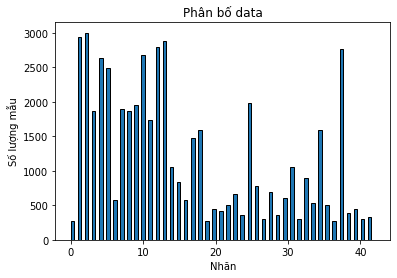

In [18]:
plt.hist(dataY, bins=n_classes, edgecolor='black', width=0.5)
plt.title('Phân bố data')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
# plt.savefig('data.png')
plt.show()

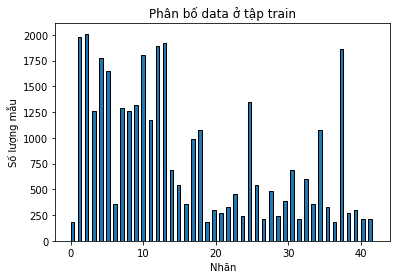

In [19]:
plt.hist(trainY, bins=n_classes, edgecolor='black', width=0.5)
plt.title('Phân bố data ở tập train')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
# plt.savefig('train.png')
plt.show()

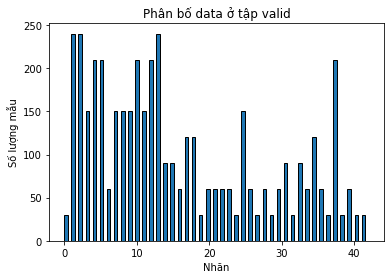

In [20]:
plt.hist(validY, bins=n_classes, edgecolor='black', width=0.5)
plt.title('Phân bố data ở tập valid')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
# plt.savefig('valid.png')
plt.show()

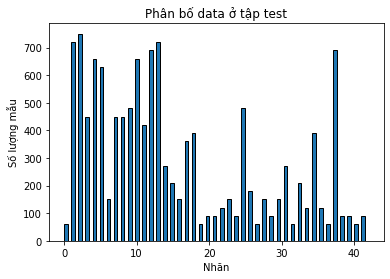

In [21]:
plt.hist(testY, bins=n_classes, edgecolor='black', width=0.5)
plt.title('Phân bố data ở tập test')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
# plt.savefig('test.png')
plt.show()

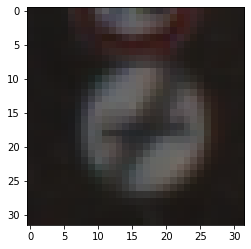

In [22]:
plt.imshow(trainX[0])

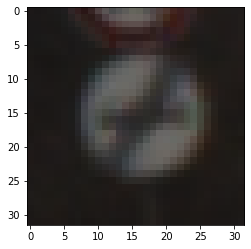

In [23]:
plt.imshow(trainX[1])

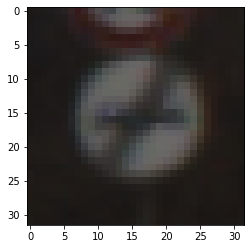

In [24]:
plt.imshow(trainX[2])

In [25]:
trainY[1]

41

## Đánh nhãn label

Như đã thấy ở trên thì labels vẫn là dạng số chưa được đánh nhãn.
Ta cần đánh nhãn cho chúng:

In [26]:
classNames = {0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right',
 39: 'Keep left',
 40: 'Roundabout mandatory',
 41: 'End of no passing',
 42: 'End of no passing by vehicles over 3.5 metric tons'}

In [27]:
classNames[trainY[1]]

'End of no passing'

## Suffle image

Ta cần tráo các dữ liệu trong tập train lên để giữ tính tổng quát khi train dữ liệu. Vì dữ liệu ban đầu có các ảnh giống nhau được đặt liền nhau và đã được sắp nhãn theo thứ tự.

In [28]:
trainX, trainY = shuffle(trainX, trainY)

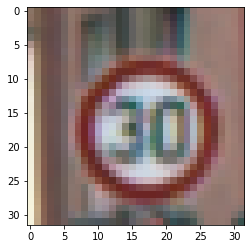

In [29]:
plt.imshow(trainX[1])

In [30]:
classNames[trainY[1]]

'Speed limit (30km/h)'

## Chuẩn hoá data

Chuẩn hóa dữ liệu từ các giá trị 0-255 về 0-1 để tăng độ chính xác (giảm độ kéo giãn giữa các điểm dữ liệu)

In [31]:
trainX = trainX.astype("float")/255.0
validX = validX.astype("float")/255.0
testX = testX.astype("float")/255.0
dataX = dataX.astype("float")/255.0

trainX[0]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 0.99607843, 0.99607843],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.98823529],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [0.98431373, 0.98431373, 0.96862745],
        ...,
        [1.        , 0.99607843, 0.99607843],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.9372549 , 0.95686275, 0.96078431],
        [0.92941176, 0.92156863, 0.9254902 ],
        [0.95686275, 0

Chuẩn hoá nhãn từ dạng số (0-42) sang dạng onehot tương ứng với vector đầu ra của mạng (43*1)

In [32]:
lb = LabelBinarizer()

In [33]:
trainY = lb.fit_transform(trainY)
validY = lb.fit_transform(validY)
testY = lb.fit_transform(testY)
dataY = lb.fit_transform(dataY)

In [34]:
valid["labels"][0]

41

In [35]:
validY[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## Tăng cường data

In [36]:
aug = ImageDataGenerator(rotation_range=0.18, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

## Input shape image

In [37]:
width = 32
height = 32
shape = (width, height, 3)

classes = 43

# Build model

## Xây dựng mô hình CNN (model 1)

### Init model

In [38]:
#Khởi tạo
model = Sequential()

In [39]:
#Block 1

model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Kiểm tra
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [40]:
#Tiếp tục với Block 2 và Block 3 theo ảnh mô hình mẫu

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Kiểm tra
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [41]:
#Duỗi ra dạng vector
model.add(Flatten())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [42]:
#Thu nhỏ dần về 43 lớp như trong mô hình
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [43]:
model.add(Dense(classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [44]:
#Cho ra kết quả có xác suất lớn nhất bằng hàm softmax
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [45]:
# learning rate
learning_rate = 0.01

# epochs
epochs = 10

# batch size 
batch_size = 64

Thuật toán để tối ưu hoá loss funtion


In [46]:
opt = SGD(learning_rate=learning_rate, momentum=0.9)

Sau đó compile thuật toán vào model

In [47]:
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

### Start training


In [48]:
# H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(validX, validY), 
#                          steps_per_epoch=trainX.shape[0]//batch_size, epochs=epochs, verbose=1)

Lưu lại quá trình train


In [49]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_1

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_1


In [50]:
#model.save("model_1.h5")

Lưu lại history của model sau khi train

In [51]:
#np.save('history_model_1.npy',H.history)

### Plot loss và accurracy

In [52]:
saved_history_model_1=np.load('history_model_1.npy',allow_pickle='TRUE').item()

Text(0.5, 0, 'epoch')

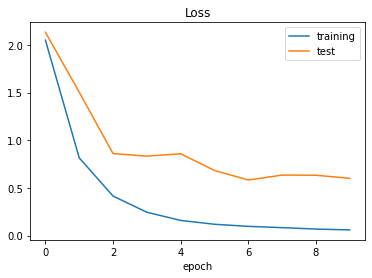

In [53]:
plt.plot(saved_history_model_1['loss'])
plt.plot(saved_history_model_1['val_loss'])
plt.legend(['training','test'])
plt.title('Loss')
plt.xlabel('epoch')
#plt.savefig('loss.png') 

Text(0.5, 0, 'epoch')

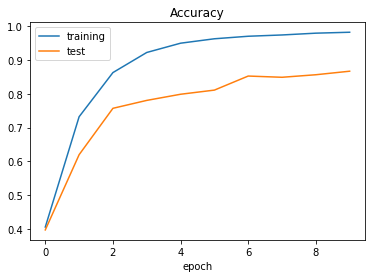

In [54]:
plt.plot(saved_history_model_1['accuracy'])
plt.plot(saved_history_model_1['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
#plt.savefig('acc.png') 

In [55]:
saved_model_1 = tf.keras.models.load_model("model_1.h5")

### Evaluation

In [56]:
model_1_score = saved_model_1.evaluate(testX, testY, verbose=1)

395/395 [==============================] - 11s 8ms/step - loss: 0.4634 - accuracy: 0.8854


In [57]:
print('Test Score:', model_1_score[0])
print('Test Accuracy:', model_1_score[1])

Test Score: 0.46344640851020813
Test Accuracy: 0.8853523135185242


### Sử dụng model đã train để predict

In [58]:
model_1_predY_hat = saved_model_1.predict(testX)

In [59]:
model_1_predY_hat

array([[3.5693752e-13, 1.3057483e-15, 2.0401131e-13, ..., 2.4900949e-14,
        1.9457363e-12, 3.0828584e-08],
       [7.8041984e-07, 9.9992836e-01, 1.3103374e-07, ..., 1.5085933e-11,
        6.1142366e-08, 2.0447029e-08],
       [2.3194870e-09, 8.8343760e-10, 3.7484067e-06, ..., 3.2362554e-05,
        5.7934274e-10, 4.3904148e-11],
       ...,
       [1.0759571e-05, 5.7426687e-06, 1.0956654e-03, ..., 1.0696894e-05,
        9.3919260e-04, 2.6619530e-03],
       [4.5853003e-08, 9.9051212e-09, 3.6060205e-10, ..., 9.7580232e-07,
        2.5365778e-09, 1.4286954e-08],
       [2.5495906e-11, 1.5624818e-09, 9.7990815e-10, ..., 7.2731887e-10,
        1.9511839e-08, 9.3226674e-08]], dtype=float32)

Trên đây là xác suất của từng class với mỗi ảnh. Ta sẽ chọn xác suất lớn nhất tương ứng với ảnh đầu vào

In [60]:
model_1_predY = np.argmax(model_1_predY_hat, axis=1)

In [61]:
model_1_predY

array([16,  1, 38, ..., 20,  7, 10])

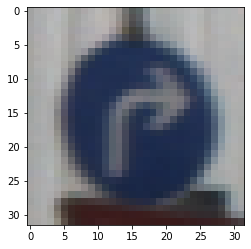

In [62]:
plt.imshow(test["features"][99])

In [63]:
classNames[model_1_predY[99]]

'Turn right ahead'

### Đánh giá các thông số Precision , Recall và F1 Score

In [64]:
testY_label =  np.argmax(testY, axis=1)

In [65]:
print(classification_report(testY_label, model_1_predY)) 

              precision    recall  f1-score   support

           0       1.00      0.63      0.78        60
           1       0.94      0.82      0.88       720
           2       0.90      0.98      0.94       750
           3       0.96      0.90      0.93       450
           4       0.93      0.93      0.93       660
           5       0.79      0.94      0.86       630
           6       0.74      0.90      0.81       150
           7       0.90      0.86      0.88       450
           8       0.81      0.94      0.87       450
           9       0.97      0.99      0.98       480
          10       1.00      0.93      0.96       660
          11       0.95      0.88      0.91       420
          12       0.98      0.97      0.97       690
          13       0.99      0.97      0.98       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      0.99       210
          16       0.99      0.99      0.99       150
          17       1.00    

### Xây dựng Confusion Matrix

In [67]:
c_matrix = metrics.confusion_matrix(testY_label, model_1_predY)

In [68]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig('confusion_matrix.png')

In [69]:
class_names= classNames.keys()
class_names

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])

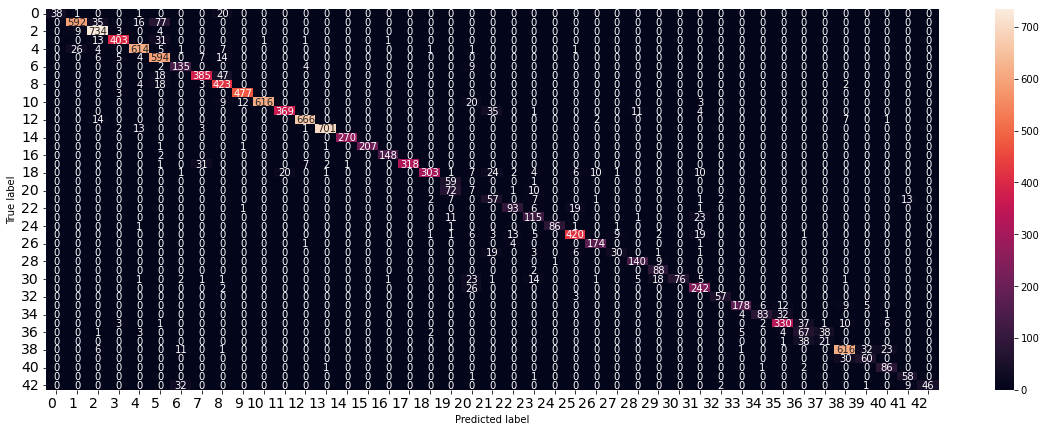

In [70]:
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

## Model 2

### Init model

Thử với opt là Adam và learning rate=0.001

In [71]:
def init_model():
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [72]:
model_2 = init_model()
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Start train

In [73]:
# history_2 = model_2.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(validX, validY), 
#                           steps_per_epoch=trainX.shape[0]//batch_size, epochs=epochs, verbose=1)

In [74]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_2


In [75]:
#model_2.save("model_2.h5")

In [76]:
# np.save('history_model_2.npy', history_2.history)

### Plot loss and acc

In [77]:
saved_model_2 = tf.keras.models.load_model("model_2.h5")

In [78]:
saved_history_model_2 = np.load('history_model_2.npy',allow_pickle='TRUE').item()

In [79]:
def plot_model_history(saved_history_model, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(saved_history_model[acc]) + 1), saved_history_model[acc])
    axs[0].plot(range(1, len(saved_history_model[val_acc]) + 1), saved_history_model[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(saved_history_model[acc]) + 1), len(saved_history_model[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1, len(saved_history_model['loss']) + 1), saved_history_model['loss'])
    axs[1].plot(range(1, len(saved_history_model['val_loss']) + 1), saved_history_model['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(saved_history_model['loss']) + 1), len(saved_history_model['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('history.png')

    plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


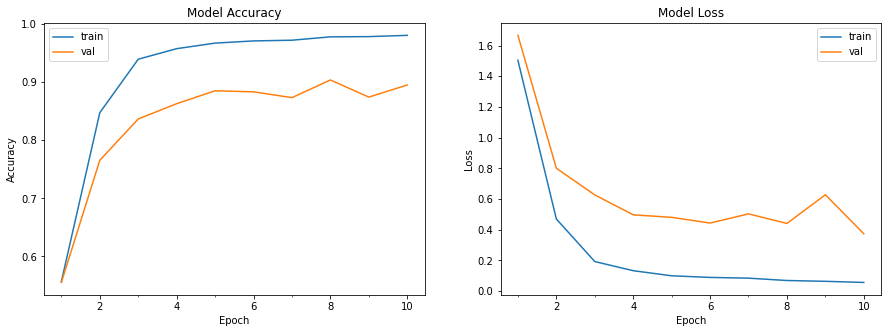

In [80]:
plot_model_history(saved_history_model_2)

### Evaluation

Đánh giá trên tập test

In [81]:
score_model_2 = saved_model_2.evaluate(testX, testY, verbose=1)

395/395 [==============================] - 3s 7ms/step - loss: 0.5291 - accuracy: 0.8850


In [82]:
print('Test Score:', score_model_2[0])
print('Test Accuracy:', score_model_2[1])

Test Score: 0.5291222333908081
Test Accuracy: 0.8849564790725708


### Predict

In [83]:
model_2_predY_hat = saved_model_2.predict(testX)
model_2_predY = np.argmax(model_2_predY_hat, axis=1)

### Đánh giá các thông số Precision , Recall và F1 Score

In [84]:
print(classification_report(testY_label, model_2_predY)) 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        60
           1       0.95      0.99      0.97       720
           2       0.99      0.88      0.93       750
           3       0.92      0.92      0.92       450
           4       0.99      0.94      0.97       660
           5       0.87      0.98      0.92       630
           6       0.88      0.67      0.76       150
           7       0.96      0.91      0.94       450
           8       0.88      0.94      0.91       450
           9       1.00      0.94      0.97       480
          10       0.97      0.98      0.98       660
          11       0.99      0.93      0.96       420
          12       0.98      0.91      0.94       690
          13       0.99      0.97      0.98       720
          14       1.00      0.97      0.99       270
          15       0.96      1.00      0.98       210
          16       0.99      0.98      0.98       150
          17       1.00    

### Xây dựng confusion matrix

In [85]:
model_2_c_matrix = metrics.confusion_matrix(testY_label, model_2_predY)

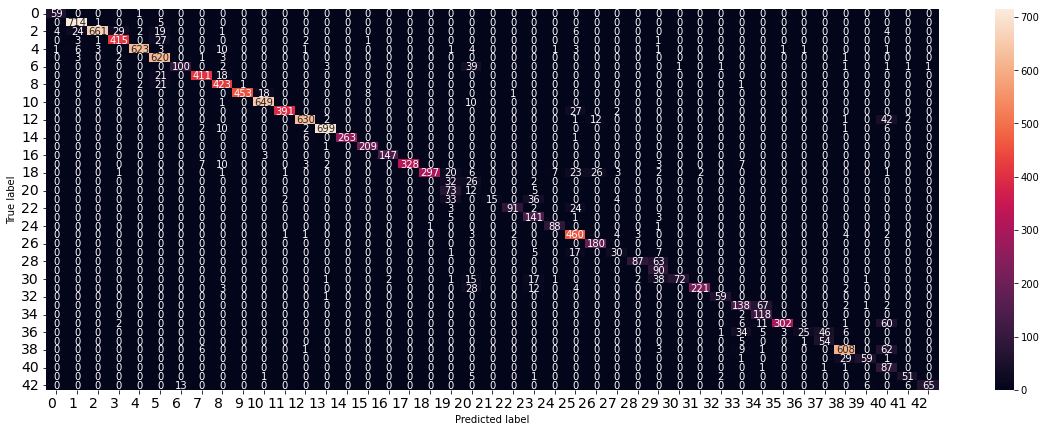

In [86]:
confusion_matrix(model_2_c_matrix, class_names, figsize = (20,7), fontsize=14)

# Optimize

## Model 2 

In [87]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_2


### Tune and Number of Epochs

In [88]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model_2_tune_epochs = KerasClassifier(build_fn=init_model, verbose=1)

# define the grid search parameters
epochs = [10, 20, 30]
param_grid = dict(epochs=epochs)
# param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model_2_tune_epochs, param_grid=param_grid, n_jobs=None, cv=3)
#grid_result = grid.fit(trainX, trainY)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [89]:
#save your model or results
#joblib.dump(grid_result, 'model_2_opt_epochs.pkl')

In [90]:
#load your model for further usage
saved_model_2_tune_epochs = joblib.load("model_2_opt_epochs.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [91]:
saved_model_2_tune_epochs.cv_results_

{'mean_fit_time': array([116.99410868, 266.88285764, 365.53060579]),
 'mean_score_time': array([3.91405606, 4.85627739, 3.12182609]),
 'mean_test_score': array([0.98833313, 0.99022975, 0.99201113]),
 'param_epochs': masked_array(data=[10, 20, 30],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'epochs': 10}, {'epochs': 20}, {'epochs': 30}],
 'rank_test_score': array([3, 2, 1], dtype=int32),
 'split0_test_score': array([0.99560344, 0.98103446, 0.99439657]),
 'split1_test_score': array([0.97698277, 0.99439657, 0.99465519]),
 'split2_test_score': array([0.99241316, 0.99525821, 0.98698163]),
 'std_fit_time': array([18.63957784, 45.12193901, 45.05246389]),
 'std_score_time': array([1.22537696, 1.10816922, 0.04538406]),
 'std_test_score': array([0.0081309 , 0.00651156, 0.00355796])}

In [92]:
saved_model_2_tune_epochs.best_params_

{'epochs': 30}

In [93]:
# summarize results
print("Best: %f using %s" % (saved_model_2_tune_epochs.best_score_, saved_model_2_tune_epochs.best_params_))
means = saved_model_2_tune_epochs.cv_results_['mean_test_score']
stds = saved_model_2_tune_epochs.cv_results_['std_test_score']
params = saved_model_2_tune_epochs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.992011 using {'epochs': 30}
0.988333 (0.008131) with: {'epochs': 10}
0.990230 (0.006512) with: {'epochs': 20}
0.992011 (0.003558) with: {'epochs': 30}


In [94]:
def plot_search_results(title, xlabel, grid_result):
  ylabel = "Accuracy"
  X = []
  Y = []
  error = []
  
  results = grid_result.cv_results_
  means_test = results['mean_test_score']
  stds_test = results['std_test_score']

  params_set = results['params']

  for i in range(len(params_set)):
    X.append(params_set[i][xlabel])
    Y.append(means_test[i])
    error.append(stds_test[i])

  plt.xlabel(xlabel)
  plt.title(title)
  plt.grid()
  plt.ylabel(ylabel)
  
  plt.errorbar(X, Y, error, linestyle='None', marker='o')

In [95]:
# cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2/images

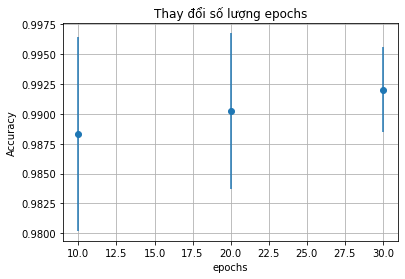

In [96]:
title = "Thay đổi số lượng epochs"
xlabel = "epochs"
plot_search_results(title, xlabel, saved_model_2_tune_epochs)
# plt.savefig('model_2__tune_epochs.png', bbox_inches='tight')
plt.show()

In [97]:
saved_model_2_tune_epochs_predY = saved_model_2_tune_epochs.predict(testX) 
saved_model_2_tune_epochs_predY

array([16,  1, 38, ...,  5,  7, 10])

In [98]:
# print classification report 
print(classification_report(testY_label, saved_model_2_tune_epochs_predY)) 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.97      0.99      0.98       720
           2       0.99      0.99      0.99       750
           3       0.98      0.95      0.97       450
           4       0.98      0.99      0.99       660
           5       0.91      0.99      0.95       630
           6       1.00      0.79      0.88       150
           7       0.94      0.97      0.96       450
           8       0.95      0.98      0.97       450
           9       0.98      1.00      0.99       480
          10       0.99      0.99      0.99       660
          11       0.98      0.99      0.99       420
          12       0.99      1.00      1.00       690
          13       0.98      0.99      0.98       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.99      0.99      0.99       150
          17       0.99    

support: Số lần xuất hiện của mỗi nhãn trong y_true

### Tune the Training Optimization Algorithm


In [99]:
def create_model_tune_opt(optimizer='adam'):
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [100]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model_2_tune_opt = KerasClassifier(build_fn=create_model_tune_opt, epochs=10, batch_size=64, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model_2_tune_opt, param_grid=param_grid, n_jobs=None, cv=3)
# grid_result = grid.fit(trainX, trainY)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [101]:
#save your model or results
#joblib.dump(grid_result, 'model_2_tune_opt.pkl')

In [102]:
#load your model for further usage
saved_model_2_tune_opt = joblib.load("model_2_tune_opt.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [103]:
# summarize results
print("Best: %f using %s" % (saved_model_2_tune_opt.best_score_, saved_model_2_tune_opt.best_params_))
means = saved_model_2_tune_opt.cv_results_['mean_test_score']
stds = saved_model_2_tune_opt.cv_results_['std_test_score']
params = saved_model_2_tune_opt.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.993994 using {'optimizer': 'SGD'}
0.993994 (0.000347) with: {'optimizer': 'SGD'}
0.992184 (0.002611) with: {'optimizer': 'RMSprop'}
0.993448 (0.005670) with: {'optimizer': 'Adam'}
0.977815 (0.000387) with: {'optimizer': 'Adagrad'}
0.510704 (0.007723) with: {'optimizer': 'Adadelta'}


In [104]:
# cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2/images

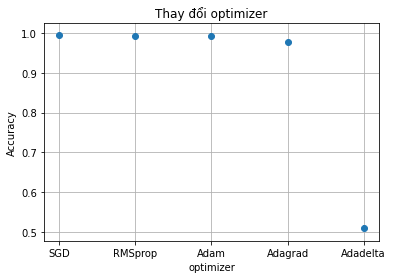

In [105]:
title = "Thay đổi optimizer"
xlabel = "optimizer"
plot_search_results(title, xlabel, saved_model_2_tune_opt)
# plt.savefig('model_2_tune_opt.png', bbox_inches='tight')
plt.show()

In [106]:
saved_model_2_tune_opt_predY = saved_model_2_tune_opt.predict(testX) 
saved_model_2_tune_opt_predY

array([16,  1, 38, ..., 20,  7, 10])

In [107]:
# print classification report 
print(classification_report(testY_label, saved_model_2_tune_opt_predY)) 

              precision    recall  f1-score   support

           0       1.00      0.57      0.72        60
           1       0.88      0.97      0.92       720
           2       0.94      0.97      0.96       750
           3       0.94      0.91      0.93       450
           4       0.95      0.94      0.95       660
           5       0.87      0.93      0.90       630
           6       0.99      0.80      0.89       150
           7       0.96      0.84      0.90       450
           8       0.89      0.93      0.91       450
           9       0.96      0.98      0.97       480
          10       0.98      0.98      0.98       660
          11       0.90      0.95      0.92       420
          12       0.97      0.96      0.97       690
          13       0.97      1.00      0.98       720
          14       0.98      0.99      0.99       270
          15       0.98      0.97      0.97       210
          16       0.99      0.98      0.99       150
          17       0.99    

### Tune Learning Rate and Momentum

In [108]:
# Function to create model, required for KerasClassifier
def create_model_tune_lr_momentum(learn_rate=0.01, momentum=0):
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [109]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model_2_tune_lr_momentum = KerasClassifier(build_fn=create_model_tune_lr_momentum, epochs=10, batch_size=64, verbose=2)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
momentum = [0.5, 0.9, 0.99]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(estimator=model_2_tune_lr_momentum, param_grid=param_grid, n_jobs=None, cv=3)
# grid_result = grid.fit(trainX, trainY)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [110]:
#save your model or results
# joblib.dump(grid_result, 'model_2_tune_lr_momentum.pkl')

In [111]:
#load your model for further usage
saved_model_2_tune_lr_momentum = joblib.load("model_2_tune_lr_momentum.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [112]:
# summarize results
print("Best: %f using %s" % (saved_model_2_tune_lr_momentum.best_score_, saved_model_2_tune_lr_momentum.best_params_))
means = saved_model_2_tune_lr_momentum.cv_results_['mean_test_score']
stds = saved_model_2_tune_lr_momentum.cv_results_['std_test_score']
params = saved_model_2_tune_lr_momentum.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997098 using {'learn_rate': 0.1, 'momentum': 0.5}
0.978994 (0.000918) with: {'learn_rate': 0.001, 'momentum': 0.5}
0.992988 (0.000615) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.995833 (0.000599) with: {'learn_rate': 0.001, 'momentum': 0.99}
0.995029 (0.000347) with: {'learn_rate': 0.01, 'momentum': 0.5}
0.996695 (0.000537) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.994914 (0.000462) with: {'learn_rate': 0.01, 'momentum': 0.99}
0.997098 (0.000528) with: {'learn_rate': 0.1, 'momentum': 0.5}
0.995287 (0.000266) with: {'learn_rate': 0.1, 'momentum': 0.9}
0.432040 (0.305633) with: {'learn_rate': 0.1, 'momentum': 0.99}


In [113]:
saved_model_2_tune_lr_momentum_predY = saved_model_2_tune_lr_momentum.predict(testX) 
saved_model_2_tune_lr_momentum_predY

array([16,  1, 38, ...,  5,  7, 10])

In [114]:
# print classification report 
print(classification_report(testY_label, saved_model_2_tune_lr_momentum_predY)) 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.95      0.99      0.97       720
           2       0.98      0.98      0.98       750
           3       0.97      0.96      0.96       450
           4       0.96      0.97      0.97       660
           5       0.93      0.96      0.95       630
           6       1.00      0.83      0.91       150
           7       0.96      0.92      0.94       450
           8       0.95      0.97      0.96       450
           9       0.98      0.99      0.98       480
          10       0.99      0.99      0.99       660
          11       0.93      0.99      0.96       420
          12       0.95      0.97      0.96       690
          13       0.98      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.97      0.97      0.97       210
          16       1.00      0.99      0.99       150
          17       0.99    

### Tune Learning Rate

In [115]:
# Function to create model, required for KerasClassifier
def create_model_tune_lr(learn_rate=0.01, momentum=0):
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [116]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model_2_tune_lr = KerasClassifier(build_fn=create_model_tune_lr, epochs=10, batch_size=64, verbose=1)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
param_grid = dict(learn_rate=learn_rate)

grid = GridSearchCV(estimator=model_2_tune_lr, param_grid=param_grid, n_jobs=None, cv=3)
# grid_result = grid.fit(trainX, trainY)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [117]:
# cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2

In [118]:
#save your model or results
# joblib.dump(grid_result, 'model_2_tune_lr.pkl')

In [119]:
#load your model for further usage
saved_model_2_tune_lr = joblib.load("model_2_tune_lr.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [120]:
# summarize results
print("Best: %f using %s" % (saved_model_2_tune_lr.best_score_, saved_model_2_tune_lr.best_params_))
means = saved_model_2_tune_lr.cv_results_['mean_test_score']
stds = saved_model_2_tune_lr.cv_results_['std_test_score']
params = saved_model_2_tune_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996638 using {'learn_rate': 0.1}
0.955286 (0.001317) with: {'learn_rate': 0.001}
0.993132 (0.000772) with: {'learn_rate': 0.01}
0.996638 (0.000679) with: {'learn_rate': 0.1}


In [121]:
# cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2/images

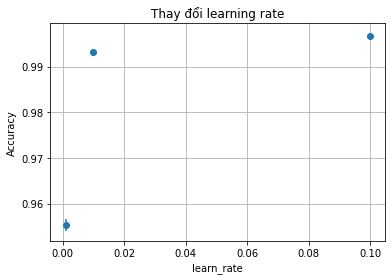

In [122]:
title = "Thay đổi learning rate"
xlabel = "learn_rate"
plot_search_results(title, xlabel, saved_model_2_tune_lr)
# plt.savefig('model_2_tune_lr.png', bbox_inches='tight')
plt.show()

In [123]:
saved_model_2_tune_lr_predY = saved_model_2_tune_lr.predict(testX) 
saved_model_2_tune_lr_predY

array([16,  1, 38, ...,  5,  7, 10])

In [124]:
# print classification report 
print(classification_report(testY_label, saved_model_2_tune_lr_predY)) 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.95      0.99      0.97       720
           2       0.92      0.99      0.95       750
           3       0.97      0.96      0.97       450
           4       0.99      0.96      0.98       660
           5       0.90      0.95      0.92       630
           6       0.99      0.73      0.84       150
           7       0.97      0.91      0.94       450
           8       0.93      0.97      0.95       450
           9       0.97      1.00      0.98       480
          10       0.99      0.99      0.99       660
          11       0.92      0.98      0.94       420
          12       0.98      0.98      0.98       690
          13       0.97      0.99      0.98       720
          14       1.00      1.00      1.00       270
          15       0.97      0.97      0.97       210
          16       0.99      0.99      0.99       150
          17       0.99    

### Tune momentum

In [125]:
# Function to create model, required for KerasClassifier
def create_model_tune_momentum(learn_rate=0.1, momentum=0):
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [126]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model_2_tune_momentum = KerasClassifier(build_fn=create_model_tune_momentum, epochs=10, batch_size=64, verbose=1)

# define the grid search parameters
momentum = [0.5, 0.9, 0.99]
param_grid = dict(momentum=momentum)

grid = GridSearchCV(estimator=model_2_tune_momentum, param_grid=param_grid, n_jobs=None, cv=3)
# grid_result = grid.fit(trainX, trainY)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [127]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_2


In [128]:
#save your model or results
# joblib.dump(grid_result, 'model_2_tune_momentum.pkl')

In [129]:
#load your model for further usage
saved_model_2_tune_momentum = joblib.load("model_2_tune_momentum.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [130]:
# summarize results
print("Best: %f using %s" % (saved_model_2_tune_momentum.best_score_, saved_model_2_tune_momentum.best_params_))
means = saved_model_2_tune_momentum.cv_results_['mean_test_score']
stds = saved_model_2_tune_momentum.cv_results_['std_test_score']
params = saved_model_2_tune_momentum.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996839 using {'momentum': 0.5}
0.996839 (0.000533) with: {'momentum': 0.5}
0.995172 (0.000998) with: {'momentum': 0.9}
0.491196 (0.149625) with: {'momentum': 0.99}


In [131]:
# cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_2/images

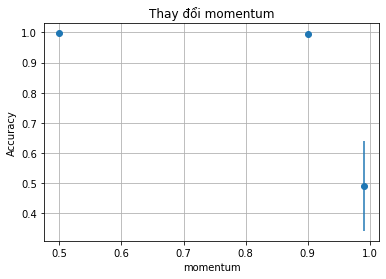

In [132]:
title = "Thay đổi momentum"
xlabel = "momentum"
plot_search_results(title, xlabel, saved_model_2_tune_momentum)
# plt.savefig('model_2_tune_momentum.png', bbox_inches='tight')
plt.show()

In [133]:
saved_model_2_tune_momentum_predY = saved_model_2_tune_momentum.predict(testX) 
saved_model_2_tune_momentum_predY

array([16,  1, 38, ...,  5,  7, 10])

In [134]:
# print classification report 
print(classification_report(testY_label, saved_model_2_tune_momentum_predY)) 

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        60
           1       0.97      0.98      0.97       720
           2       0.98      0.99      0.99       750
           3       0.98      0.95      0.97       450
           4       0.98      0.98      0.98       660
           5       0.93      0.97      0.95       630
           6       1.00      0.78      0.88       150
           7       0.99      0.91      0.95       450
           8       0.91      0.99      0.95       450
           9       0.98      0.99      0.98       480
          10       0.98      0.98      0.98       660
          11       0.90      0.99      0.95       420
          12       0.96      0.99      0.97       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.97      0.99      0.98       210
          16       0.99      1.00      1.00       150
          17       1.00    

## Build new model 3

Xây dựng model 3 sau các bước hiệu chỉnh bên trên

### Init model

In [135]:
def create_model_3():
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  optimizer = SGD(lr=0.1, momentum=0.5)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [136]:
model_3 = create_model_3()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [137]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

### Start train

In [138]:
# history_3 = model_3.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(validX, validY), 
#                           steps_per_epoch=trainX.shape[0]//batch_size, epochs=epochs, verbose=1)

In [139]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_3

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_3


In [140]:
# model_3.save("model_3.h5")

In [141]:
# np.save('history_model_3.npy', history_3.history)

### Plot loss and acc

In [142]:
saved_model_3 = tf.keras.models.load_model("model_3.h5")

In [143]:
saved_history_model_3 = np.load('history_model_3.npy',allow_pickle='TRUE').item()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


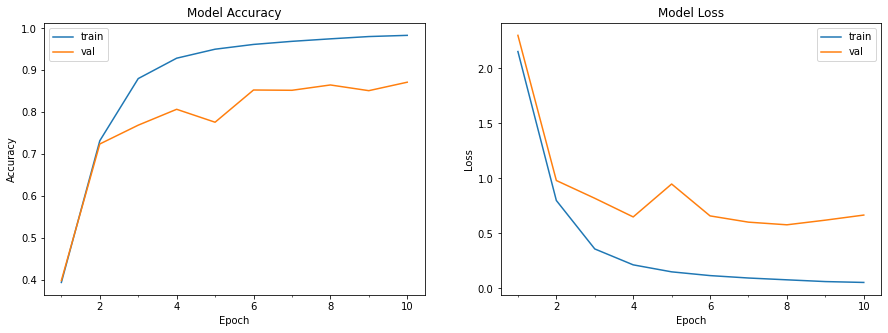

In [144]:
plot_model_history(saved_history_model_3)

### Evaluation

Đánh giá trên tập test

In [145]:
score_model_3 = saved_model_3.evaluate(testX, testY, verbose=1)

395/395 [==============================] - 3s 7ms/step - loss: 0.4024 - accuracy: 0.9011


In [146]:
print('Test Score:', score_model_3[0])
print('Test Accuracy:', score_model_3[1])

Test Score: 0.40244632959365845
Test Accuracy: 0.90110844373703


### Predict

In [147]:
model_3_predY_hat = saved_model_3.predict(testX)
model_3_predY = np.argmax(model_3_predY_hat, axis=1)

### Đánh giá các thông số Precision , Recall và F1 Score

In [148]:
print(classification_report(testY_label, model_3_predY)) 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.89      0.98      0.93       720
           2       0.89      0.90      0.90       750
           3       0.95      0.88      0.92       450
           4       0.97      0.94      0.95       660
           5       0.88      0.91      0.90       630
           6       0.99      0.73      0.84       150
           7       0.84      0.96      0.90       450
           8       0.95      0.87      0.91       450
           9       0.98      0.99      0.98       480
          10       0.97      0.99      0.98       660
          11       0.95      0.91      0.93       420
          12       0.99      0.94      0.97       690
          13       0.98      0.99      0.99       720
          14       0.87      1.00      0.93       270
          15       0.97      1.00      0.98       210
          16       0.99      0.99      0.99       150
          17       1.00    

So sánh với model 2 các chỉ số đều cao hơn

### Xây dựng confusion matrix

In [149]:
model_3_c_matrix = metrics.confusion_matrix(testY_label, model_3_predY)

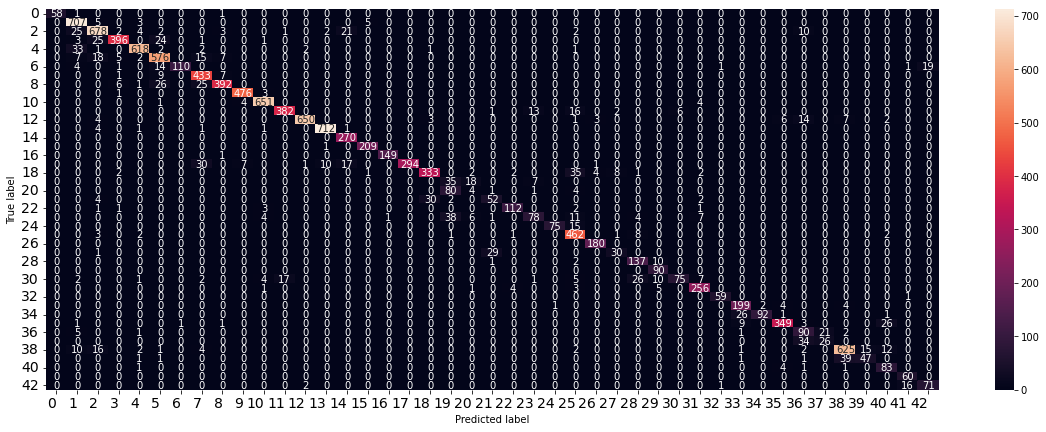

In [150]:
confusion_matrix(model_3_c_matrix, class_names, figsize = (20,7), fontsize=14)

## Train model 3 với số lượng epoch lớn hơn

### Start train

In [151]:
model_3_50_epochs = create_model_3()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [152]:
# history_3_50_epochs = model_3_50_epochs.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(validX, validY), 
#                           steps_per_epoch=trainX.shape[0]//batch_size, epochs=50, verbose=1)

In [153]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_3/model_3_50_epochs

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_3/model_3_50_epochs


In [154]:
# model_3_50_epochs.save("model_3_50_epochs.h5")

In [155]:
# np.save('history_model_3_50_epochs.npy', history_3_50_epochs.history)

### Plot loss and acc

In [156]:
saved_model_3_50_epochs = tf.keras.models.load_model("model_3_50_epochs.h5")

In [157]:
saved_history_model_3_50_epochs = np.load('history_model_3_50_epochs.npy',allow_pickle='TRUE').item()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


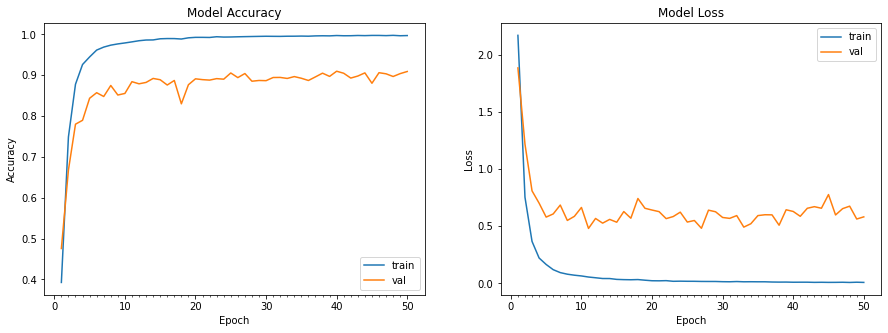

In [158]:
plot_model_history(saved_history_model_3_50_epochs)

### Evaluation

Đánh giá trên tập test

In [159]:
score_model_3_50_epochs = saved_model_3_50_epochs.evaluate(testX, testY, verbose=1)

395/395 [==============================] - 3s 7ms/step - loss: 0.4143 - accuracy: 0.9238


In [160]:
print('Test Score:', score_model_3_50_epochs[0])
print('Test Accuracy:', score_model_3_50_epochs[1])

Test Score: 0.41430339217185974
Test Accuracy: 0.9238321185112


### Predict

In [161]:
model_3_50_epochs_predY_hat = saved_model_3_50_epochs.predict(testX)
model_3_50_epochs_predY = np.argmax(model_3_50_epochs_predY_hat, axis=1)

### Đánh giá các thông số Precision , Recall và F1 Score

In [162]:
print(classification_report(testY_label, model_3_50_epochs_predY)) 

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        60
           1       0.88      1.00      0.93       720
           2       0.96      0.91      0.94       750
           3       1.00      0.95      0.97       450
           4       0.99      0.94      0.97       660
           5       0.94      0.96      0.95       630
           6       0.98      0.83      0.90       150
           7       0.94      0.97      0.95       450
           8       0.96      0.98      0.97       450
           9       0.98      0.98      0.98       480
          10       0.98      0.99      0.98       660
          11       0.96      0.99      0.97       420
          12       0.93      0.91      0.92       690
          13       0.98      1.00      0.99       720
          14       0.99      1.00      0.99       270
          15       1.00      0.99      1.00       210
          16       0.94      1.00      0.97       150
          17       1.00    

So sánh với model 2 các chỉ số đều cao hơn

### Xây dựng confusion matrix

In [163]:
model_3_50_epochs_c_matrix = metrics.confusion_matrix(testY_label, model_3_50_epochs_predY)

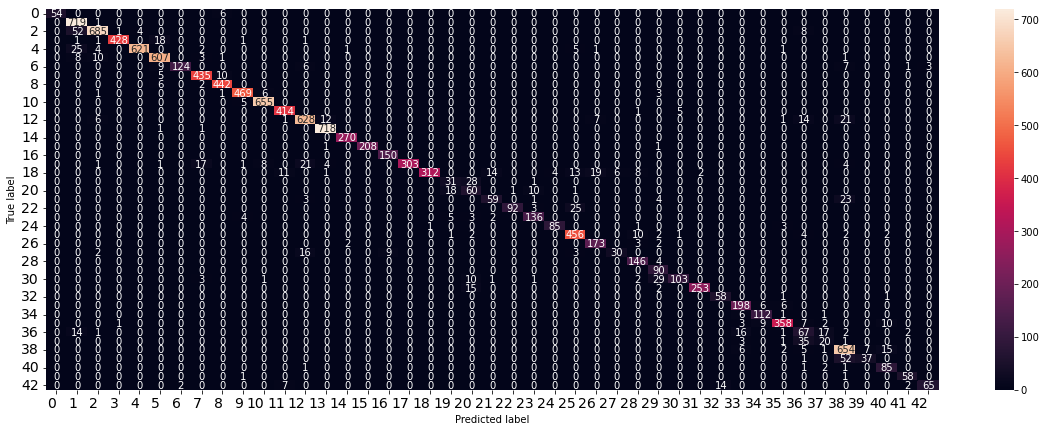

In [164]:
confusion_matrix(model_3_50_epochs_c_matrix, class_names, figsize = (20,7), fontsize=14)

## Thêm vào model 3 dropout layer

In [165]:
def create_model_add_dropout():
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  optimizer = SGD(lr=0.1, momentum=0.5)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [166]:
model_3_new = create_model_add_dropout()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [167]:
model_3_new.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_24 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_25 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

### Start train

In [168]:
# history_3_new = model_3_new.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(validX, validY), 
#                           steps_per_epoch=trainX.shape[0]//batch_size, epochs=epochs, verbose=1)

In [169]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_3_new

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_3_new


In [170]:
# model_3_new.save("model_3_new.h5")

In [171]:
# np.save('history_model_3_new.npy', history_3_new.history)

### Plot loss and acc

In [172]:
saved_model_3_new = tf.keras.models.load_model("model_3_new.h5")

In [173]:
saved_history_model_3_new = np.load('history_model_3_new.npy',allow_pickle='TRUE').item()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


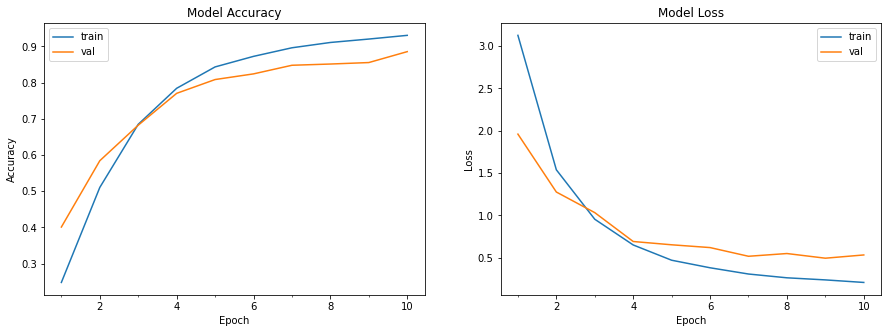

In [174]:
plot_model_history(saved_history_model_3_new)

### Evaluation

Đánh giá trên tập test

In [175]:
score_model_3_new = saved_model_3_new.evaluate(testX, testY, verbose=1)

395/395 [==============================] - 3s 7ms/step - loss: 0.4388 - accuracy: 0.8835


In [176]:
print('Test Score:', score_model_3_new[0])
print('Test Accuracy:', score_model_3_new[1])

Test Score: 0.43883851170539856
Test Accuracy: 0.8834521174430847


### Predict

In [177]:
model_3_new_predY_hat = saved_model_3_new.predict(testX)
model_3_new_predY = np.argmax(model_3_new_predY_hat, axis=1)

### Đánh giá các thông số Precision , Recall và F1 Score

In [178]:
print(classification_report(testY_label, model_3_new_predY)) 

              precision    recall  f1-score   support

           0       0.90      0.73      0.81        60
           1       0.85      0.94      0.89       720
           2       0.91      0.87      0.89       750
           3       0.97      0.92      0.95       450
           4       0.93      0.89      0.91       660
           5       0.86      0.93      0.89       630
           6       0.99      0.69      0.82       150
           7       0.93      0.90      0.92       450
           8       0.82      0.92      0.87       450
           9       0.99      0.98      0.99       480
          10       0.98      1.00      0.99       660
          11       0.95      0.93      0.94       420
          12       0.95      0.91      0.93       690
          13       0.99      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       1.00      0.97      0.98       210
          16       0.91      0.99      0.95       150
          17       1.00    

Thấy bị giảm so với model 3

### Xây dựng confusion matrix

In [179]:
model_3_new_c_matrix = metrics.confusion_matrix(testY_label, model_3_new_predY)

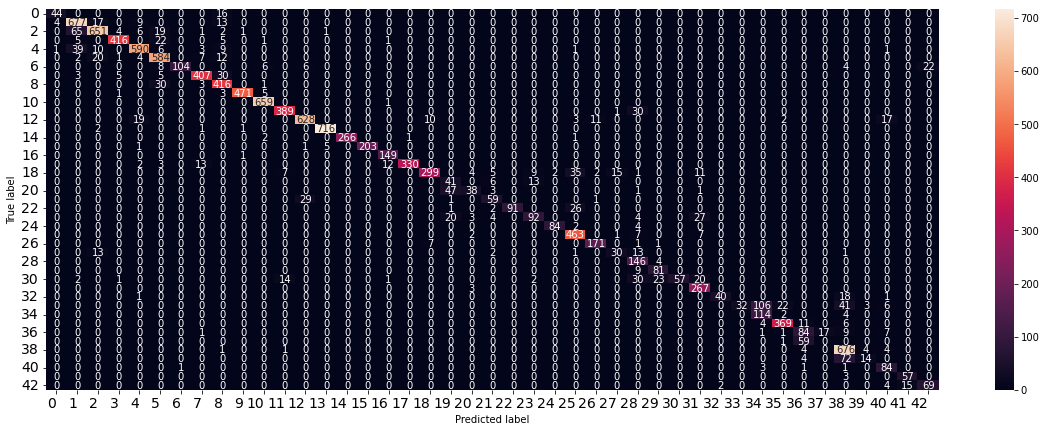

In [180]:
confusion_matrix(model_3_new_c_matrix, class_names, figsize = (20,7), fontsize=14)

# Evaluation

## Init final model

In [181]:
def create_final_model():
  model = Sequential()
  
  #block1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #block2
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())

  model.add(Dense(classes))

  model.add(Activation("softmax"))
  
  #Compile Model
  optimizer = SGD(learning_rate=0.1, momentum=0.5)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [182]:
model_final = create_final_model()
model_final.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_30 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_31 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

## Train với Stratified K-Fold

In [183]:
k_fold = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

In [184]:
accs, precs, recs, f1s = [], [], [], []
batch_size = 64
epochs = 10
fold_idx = 1

In [185]:
dataX.shape

(51839, 32, 32, 3)

In [186]:
dataY

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [187]:
dataY.argmax(1)

array([41, 41, 41, ...,  6,  7, 10])

Tiến hành train và evaluation 

In [188]:
# for train_index, test_index in k_fold.split(dataX, dataY.argmax(1)):
#   x_train, x_test = dataX[train_index], dataX[test_index]
#   y_train, y_test = dataY[train_index], dataY[test_index]

#   model = create_final_model()

#   # #train
#   print("Bắt đầu train Fold ", fold_idx)
#   history = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size), 
#                           steps_per_epoch=x_train.shape[0]//batch_size, epochs=epochs, verbose=1)
#   #predict
#   y_pred_hat = model.predict(x_test)
#   y_pred = np.argmax(y_pred_hat, axis=1)

#   y_test_label =  np.argmax(y_test, axis=1)

#   #tính các độ đo
#   acc = accuracy_score(y_test_label, y_pred)
#   prec = precision_score(y_test_label, y_pred, average='macro')
#   rec = recall_score(y_test_label, y_pred, average='macro')
#   f1 = f1_score(y_test_label, y_pred, average='macro')

#   accs.append(acc)
#   precs.append(prec)
#   recs.append(rec)
#   f1s.append(f1)
#   print("Đã train xong Fold ", fold_idx)
#   print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1-score: {f1}')

#   # Chuyển sang fold tiếp theo
#   fold_idx = fold_idx + 1

## Đánh giá

In [189]:
cd /content/gdrive/MyDrive/BTL_ML/saved_model/model_final

/content/gdrive/.shortcut-targets-by-id/1jtwQ01KKNN4OXDf7MeivMACQRgfTwAWd/BTL_ML/saved_model/model_final


In [190]:
# np.save("accs", accs)
# np.save("precs", precs)
# np.save("recs", recs)
# np.save("f1s", f1s)
accs=np.load('/content/gdrive/MyDrive/BTL_ML/saved_model/model_final/accs.npy')
precs=np.load('/content/gdrive/MyDrive/BTL_ML/saved_model/model_final/precs.npy')
recs=np.load('/content/gdrive/MyDrive/BTL_ML/saved_model/model_final/recs.npy')
f1s=np.load('/content/gdrive/MyDrive/BTL_ML/saved_model/model_final/f1s.npy')


In [191]:
# In kết quả tổng thể
print('* Chi tiết các fold')
for i in range(0, len(accs)):
  print(f'> Fold {i+1} - Acc: {accs[i]} - Precision: {precs[i]} - Recall: {recs[i]} - F1-score{f1s[i]}')

print('* Đánh giá tổng thể các folds:')
print(f'> Accuracy: {np.mean(accs)} (Độ lệch +- {np.std(accs)}), Precision: {np.mean(precs)}, Recall: {np.mean(recs)}, F1-score: {np.mean(f1s)}')

* Chi tiết các fold
> Fold 1 - Acc: 0.9910300925925926 - Precision: 0.9890435765436904 - Recall: 0.9833209127591683 - F1-score0.9857360616164963
> Fold 2 - Acc: 0.9583333333333334 - Precision: 0.9579379598488933 - Recall: 0.9328835217837294 - F1-score0.9389265711568118
> Fold 3 - Acc: 0.9821566358024691 - Precision: 0.9743129051179372 - Recall: 0.969705782508571 - F1-score0.9713647216182809
> Fold 4 - Acc: 0.9801311728395061 - Precision: 0.97312477888624 - Recall: 0.9703728017750811 - F1-score0.9702600766624748
> Fold 5 - Acc: 0.9876531301244333 - Precision: 0.9822810687703006 - Recall: 0.9848312454446166 - F1-score0.9828119952298042
* Đánh giá tổng thể các folds:
> Accuracy: 0.9798608729384668 (Độ lệch +- 0.011438962281161511), Precision: 0.9753400578334125, Recall: 0.9682228528542334, F1-score: 0.9698198852567735


<BarContainer object of 5 artists>

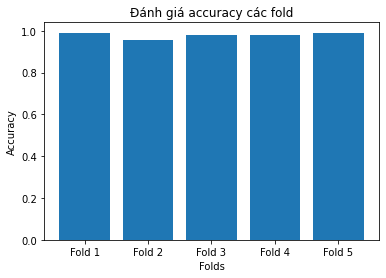

In [192]:
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
plt.title("Đánh giá accuracy các fold")
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.bar(folds, accs)
# plt.savefig('accs.png')

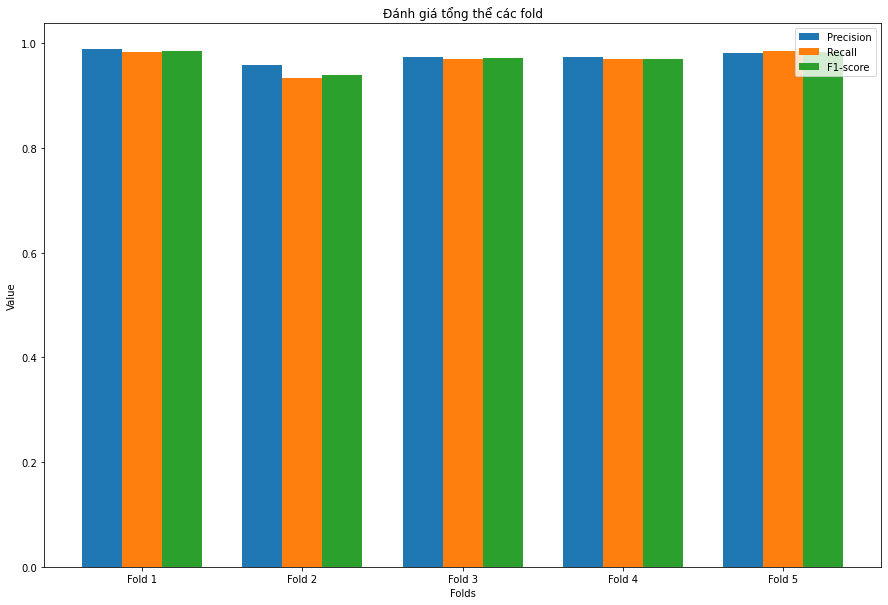

In [193]:
plt.figure(figsize=[15, 10])
X = np.arange(len(accs))
plt.bar(X, precs, width = 0.25)
plt.bar(X + 0.25, recs, width = 0.25)
plt.bar(X + 0.5, f1s, width = 0.25)
# plt.bar(X + 0.75, f1s, color = 'r', width = 0.25)

plt.legend(['Precision', 'Recall', 'F1-score'])
plt.xticks([i + 0.25 for i in range(5)], folds)
plt.title("Đánh giá tổng thể các fold")
plt.xlabel('Folds')
plt.ylabel('Value')

# plt.savefig('evaluation.png')
plt.show()